# Paso 1. Configuración del entorno

In [41]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Paso 2. Dataset QSAR Biodegradation

In [42]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = fetch_openml(data_id=1494, as_frame=True)
df = data.frame

print("Shape:", df.shape)
print("Columnas:", df.columns.tolist())
print("Tipos:\n", df.dtypes)
print("Valores únicos en 'class':", df['Class'].unique())

Shape: (1055, 42)
Columnas: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'Class']
Tipos:
 V1        float64
V2        float64
V3          int64
V4          int64
V5          int64
V6          int64
V7          int64
V8        float64
V9          int64
V10         int64
V11         int64
V12       float64
V13       float64
V14       float64
V15       float64
V16         int64
V17       float64
V18       float64
V19         int64
V20         int64
V21         int64
V22       float64
V23         int64
V24         int64
V25         int64
V26         int64
V27       float64
V28       float64
V29         int64
V30       float64
V31       float64
V32         int64
V33         int64
V34         int64
V35         int64
V36       float64
V37       float64
V38       

In [43]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2


In [44]:
df['Class'] = df['Class'].map({'2': 1, '1': 0})

X = df.drop(columns=['Class'])

y = df['Class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy().astype("int32")
y_test = y_test.to_numpy().astype("int32")

# Paso 3. Creación del experimento en MLflow

In [47]:
import mlflow

mlflow.set_experiment("clasificacion_binaria")

2025/11/04 07:30:31 INFO mlflow.tracking.fluent: Experiment with name 'clasificacion_binaria' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/kenma/work/mlops/mlflow_lab2/mlruns/365000731183770781', creation_time=1762259431699, experiment_id='365000731183770781', last_update_time=1762259431699, lifecycle_stage='active', name='clasificacion_binaria', tags={}>

# Paso 4. Modelo 1 – Regresión Logística (Scikit-learn)

2025/11/04 07:30:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 07:30:45 WARNING mlflow.utils.requirements_utils: Found lz4 version (4.0.2+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==4.0.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 07:30:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LogisticRegression_QSAR'.
Created version '1' of model 'LogisticRegression_QSAR'.


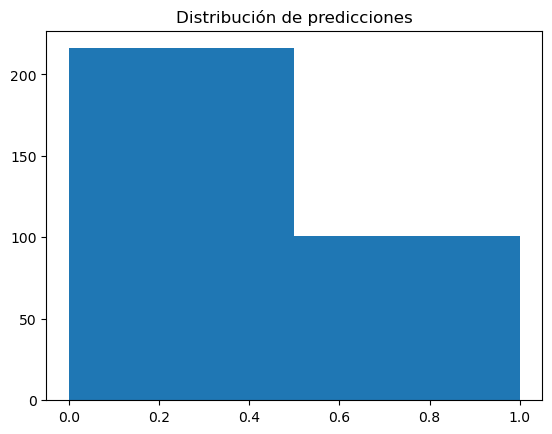

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Hiperparámetros
C = 1.0
max_iter = 500
solver = "liblinear"
penalty = "l2"

with mlflow.start_run(run_name="logistic_regression_manual") as run:

    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, penalty=penalty)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    mlflow.log_param("C", C)
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)
    mlflow.log_param("penalty", penalty)


    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    mlflow.set_tags({
        "author": "Grupo_MLOps",
        "purpose": "Clasificación binaria con dataset qsar-biodeg"
    })

    plt.figure()
    plt.hist(y_pred, bins=2)
    plt.title("Distribución de predicciones")
    plt.savefig("predicciones.png")
    mlflow.log_artifact("predicciones.png")

    mlflow.log_text("Modelo de regresión logística entrenado en dataset qsar-biodeg", "notas.txt")

    mlflow.log_dict({"dataset": "qsar-biodeg", "target": "Class"}, "config.json")

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        registered_model_name="LogisticRegression_QSAR")

# Paso 5. Modelo 2 – Red Neuronal (TensorFlow/Keras)

In [49]:
import tensorflow as tf
import mlflow.tensorflow

# Activar autologging
mlflow.tensorflow.autolog()

model_nn = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


model_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [50]:
with mlflow.start_run(run_name="keras_autologging"):
    history = model_nn.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        verbose=0
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2025/11/04 20:10:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


# Paso 7. Interpretación con Ollama

In [9]:
import mlflow
from openai import OpenAI
import os

ollama = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

prompt1 = "¿Que significa un accuracy de 0.904 en un modelo de deep learning?"
prompt2 = "¿Por que una red neuronal puede tardar mas tiempo y consumir mas recursos para dar resultados similares a una regresion logistica que es mas sencilla?"
prompt3 = "¿Que podria mejorar el rendimiento de un modelo de regresion logistica y una red neuronal en el dataset qsar-biodeg?"


def ejecutar_llm(nombre_modelo, cliente, proveedor, temperatura, registry_name):
    mlflow.set_experiment("llm_chat_response")

    with mlflow.start_run(run_name=f"{registry_name}_run") as run:

        # Se ejecutan los 3 prompts para que los interprete y se guardan
        for i, prompt in enumerate([prompt1, prompt2, prompt3], start=1):
            response = cliente.chat.completions.create(
                model=nombre_modelo,
                messages=[{"role": "user", "content": prompt}],
                temperature=temperatura
            )
        
            texto = response.choices[0].message.content
            tokens = response.usage.total_tokens
        
            # Log de parámetros
            mlflow.log_param("modelo", nombre_modelo)
            mlflow.log_param("temperatura", temperatura)
            mlflow.log_param("proveedor", proveedor)
        
            # Log de métricas
            mlflow.log_metric(f"tokens_{i}", tokens)  # opcional: distinguir por ciclo
        
            # Artefactos con numeración
            prompt_file = f"prompt_{i}.txt"
            respuesta_file = f"respuesta_{i}.txt"
        
            with open(prompt_file, "w") as f:
                f.write(prompt)
            with open(respuesta_file, "w") as f:
                f.write(texto)
        
            mlflow.log_artifact(prompt_file)
            mlflow.log_artifact(respuesta_file)

            if os.path.exists(respuesta_file):
                os.remove(respuesta_file)
            if os.path.exists(prompt_file):
                os.remove(prompt_file)

# Solo hace falta ejecutarlo una vez
ejecutar_llm("llama3.2:3b", ollama, "Ollama", 0.7, "llm_ollama_chat")


# Paso 8. Runs Anidados y Autologging Combinado

In [10]:
# Codigo tomado de la documentacion oficial de tensorflow para mlflow https://mlflow.org/docs/latest/ml/deep-learning/tensorflow/guide
import mlflow
from tensorflow import keras
import optuna

mlflow.tensorflow.autolog()

def create_model(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True)
    units = trial.suggest_int("units", 16, 32)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Create model with suggested hyperparameters
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(X_train_scaled.shape[1],)),
            keras.layers.Flatten(),
            keras.layers.Dense(units, activation="relu"),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(units, activation="relu"),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


def objective(trial):
    # Start nested run for this trial
    with mlflow.start_run(nested=True):
        model = create_model(trial)
        # Log hyperparameters
        params = {
            "learning_rate": trial.params["learning_rate"],
            "units": trial.params["units"],
            "dropout": trial.params["dropout"],
        }
        mlflow.log_params(params)

        # Create and train model
        history = model.fit(
            X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=10, verbose=0
        )

        # Get validation accuracy
        val_accuracy = max(history.history["val_accuracy"])
        mlflow.log_metric("val_accuracy", val_accuracy)

        # Log model
        mlflow.tensorflow.log_model(model, name="tensorflow_child_model")

        return val_accuracy

In [11]:
# Main experiment run
mlflow.set_experiment("tensorflow_nested_hyperparameter_optimization")
with mlflow.start_run(run_name="tensorflow_nested"):
    # Log study parameters
    mlflow.log_params(
        {
            "optimization_framework": "optuna",
            "n_trials": 10,
            "direction": "maximize",
            "metric": "val_accuracy",
        }
    )

    # Create and run study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    # Log best parameters and score
    mlflow.log_params({f"best_{k}": v for k, v in study.best_params.items()})
    mlflow.log_metric("best_val_accuracy", study.best_value)

    # Train final model with best parameters
    final_model = create_model(study.best_trial)
    final_model.fit(X_train_scaled, y_train, epochs=10)
    mlflow.tensorflow.log_model(final_model, name="best_child_model")

[I 2025-11-04 20:11:18,819] A new study created in memory with name: no-name-321fab4b-f63d-4bb8-9918-47b8f8fdcc89


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2025/11/04 20:11:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:11:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:11:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:11:30,629] Trial 0 finished with value: 0.8769716024398804 and parameters: {'learning_rate': 0.038888611711296414, 'units': 25, 'dropout': 0.34774861904525634}. Best is trial 0 with value: 0.8769716024398804.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2025/11/04 20:11:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:11:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:11:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:11:43,421] Trial 1 finished with value: 0.8801261782646179 and parameters: {'learning_rate': 0.017673453824997135, 'units': 17, 'dropout': 0.3954831643363337}. Best is trial 1 with value: 0.8801261782646179.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025/11/04 20:11:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:11:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:11:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:11:56,019] Trial 2 finished with value: 0.8738170266151428 and parameters: {'learning_rate': 0.022457282838138665, 'units': 23, 'dropout': 0.4097813656354472}. Best is trial 1 with value: 0.8801261782646179.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


2025/11/04 20:11:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:12:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:12:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:12:08,547] Trial 3 finished with value: 0.8832807540893555 and parameters: {'learning_rate': 0.03875814640383361, 'units': 25, 'dropout': 0.10689517925214705}. Best is trial 3 with value: 0.8832807540893555.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


2025/11/04 20:12:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:12:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:12:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:12:21,765] Trial 4 finished with value: 0.8738170266151428 and parameters: {'learning_rate': 0.014713735665079665, 'units': 26, 'dropout': 0.3333211405096823}. Best is trial 3 with value: 0.8832807540893555.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2025/11/04 20:12:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:12:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:12:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:12:33,573] Trial 5 finished with value: 0.8391166925430298 and parameters: {'learning_rate': 0.05139305385918233, 'units': 21, 'dropout': 0.4825967517819437}. Best is trial 3 with value: 0.8832807540893555.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2025/11/04 20:12:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:12:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:12:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:12:46,067] Trial 6 finished with value: 0.886435329914093 and parameters: {'learning_rate': 0.014866094631881939, 'units': 27, 'dropout': 0.10740657662893338}. Best is trial 6 with value: 0.886435329914093.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2025/11/04 20:12:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:12:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:12:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:12:57,535] Trial 7 finished with value: 0.8706624507904053 and parameters: {'learning_rate': 0.06066398596413293, 'units': 21, 'dropout': 0.41587605932588567}. Best is trial 6 with value: 0.886435329914093.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


2025/11/04 20:12:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:13:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:13:08,971] Trial 8 finished with value: 0.8927444815635681 and parameters: {'learning_rate': 0.02366706749810144, 'units': 28, 'dropout': 0.20660908651507928}. Best is trial 8 with value: 0.8927444815635681.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2025/11/04 20:13:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:13:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:13:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-11-04 20:13:20,246] Trial 9 finished with value: 0.8832807540893555 and parameters: {'learning_rate': 0.0245144210883304, 'units': 30, 'dropout': 0.3882091176404818}. Best is trial 8 with value: 0.8927444815635681.


Epoch 1/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.3125 - loss: 0.8213

2025/11/04 20:13:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7737 - loss: 0.4940   
Epoch 2/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8438 - loss: 0.3637

2025/11/04 20:13:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8550 - loss: 0.3455 
Epoch 3/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8750 - loss: 0.4489

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.3300 
Epoch 4/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8438 - loss: 0.3202

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8713 - loss: 0.2952 
Epoch 5/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8750 - loss: 0.3951

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8862 - loss: 0.2932 
Epoch 6/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - loss: 0.2704

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.2874 
Epoch 7/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8438 - loss: 0.2846

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8835 - loss: 0.2779 
Epoch 8/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9062 - loss: 0.1936

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8889 - loss: 0.2822 
Epoch 9/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7812 - loss: 0.4073

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8848 - loss: 0.2558 
Epoch 10/10
 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - loss: 0.3499

2025/11/04 20:13:21 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8862 - loss: 0.2839 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025/11/04 20:13:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 20:13:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/04 20:13:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
